In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms, models
import pandas as pd
import os
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
import cv2
import multiprocessing as mp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split


df = pd.read_csv('./data.csv', names=["id", "image", "published", "disabled"], header=None)

df['available'] = 0

all_images_path = 'data/all_images'

for i, row in df.iterrows():
    file = os.path.join(all_images_path, row['id'] + '.jpg')
    if os.path.isfile(file):
        df.at[i, 'available'] = 1


num_of_sample_per_class = 3000   

published_df = df.loc[df.query('available == 1 and published == 1').index, :]
published_df = published_df.reset_index(drop=True).loc[:num_of_sample_per_class, :]
disabled_df = df.query('available == 1 and disabled == 1')
disabled_df = disabled_df.reset_index(drop=True).loc[:num_of_sample_per_class, :]


all_data_df = pd.concat([published_df, disabled_df], ignore_index=True)
all_data_df    

,id,image,published,disabled,available
0,5e5836fee917e8d9a8a7b277,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
1,5e58343ded065ad79e312f3d,https://scontent.xx.fbcdn.net/v/t51.2885-15/85...,1,0,1
2,5e57dc939e88b6be2ac42800,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
3,5e55dca437fa5927dcdf02f3,https://scontent.xx.fbcdn.net/v/t51.2885-15/81...,1,0,1
4,5e55d69eb9e5b725cd7ba02f,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
...,...,...,...,...,...
5917,5e3abda8c69973857ea8127b,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1
5918,5e3abda8c69973857ea8127c,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1
5919,5e3abda8c69973857ea8127d,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1
5920,5e3ab900f2fa52836dbf036d,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1


In [2]:
train_df, test_df = train_test_split(all_data_df, test_size=0.4, random_state=42)
validation_df, test_df = train_test_split(test_df, test_size=0.3, random_state=42)
print('train df {}, validation df {}, test df {}'.format(len(train_df),len(validation_df),len(test_df)))
print('train: published {}, disabled {}'.format(
        len(train_df.loc[train_df['published'] == 1, :]),
        len(train_df.loc[train_df['disabled'] == 1, :])))
print('validation: published {}, disabled {}'.format(
        len(validation_df.loc[validation_df['published'] == 1, :]),
        len(validation_df.loc[validation_df['disabled'] == 1, :])))
print('test: published {}, disabled {}'.format(
        len(test_df.loc[test_df['published'] == 1, :]),
        len(test_df.loc[test_df['disabled'] == 1, :])))


train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train df 3553, validation df 1658, test df 711
train: published 1731, disabled 1822
validation: published 824, disabled 834
test: published 366, disabled 345


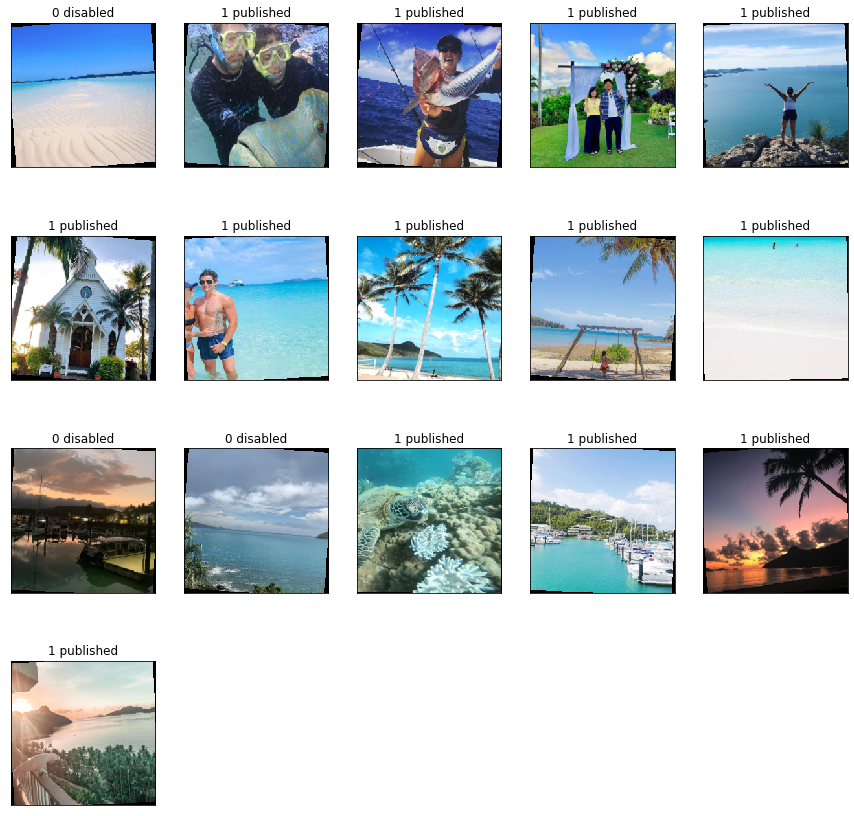

In [3]:
train_on_gpu = torch.cuda.is_available()

torch.manual_seed(0)

class MyDataset(Dataset):
    def __init__(self, data_df, all_images_path, transform=None):
        super().__init__()
        self.data_df = data_df
        self.transform = transform
        self.all_images_path = all_images_path
        
    def __getitem__(self, index):
        _id = self.data_df.loc[index, 'id']
        label = 0 if self.data_df.loc[index, 'disabled'] else 1
                
        file = os.path.join(self.all_images_path, _id + '.jpg')
        
        img = mpimg.imread(file)        
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
        
    def __len__(self):
        return len(self.data_df)

        
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    normalize
])        

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize    
])


# visualise data
def visualise_data(data_loader, classes):    
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    
    num_of_samples = labels.size(0)
    num_cols = 5

    fig = plt.figure(figsize=(15, 15))
    for i in range(num_of_samples):
        ax = fig.add_subplot(num_of_samples//num_cols + 1, num_cols, i+1, xticks=[], yticks=[])
        image = images[i]
        image = inv_normalize(image)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        label = labels[i]
        ax.set_title(f"{label} {classes[label]}")

        

# create Dataloader
batch_size = 16
all_images_path = 'data/all_images'

train_dataset = MyDataset(train_df, all_images_path, train_transform)
validation_dataset = MyDataset(validation_df, all_images_path, test_transform)
test_dataset = MyDataset(test_df, all_images_path, test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

classes = ['disabled', 'published']
visualise_data(train_dataloader, classes)

In [5]:
for i, (images, labels) in enumerate(train_dataloader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16])


In [4]:
def get_model(classes):  
    num_output_classes = len(classes)
    pretrained_model = models.mobilenet_v2(pretrained=True)    
    in_feature = pretrained_model.classifier[-1].in_features
    pretrained_model.classifier[-1] = torch.nn.Linear(in_feature, num_output_classes)
    return pretrained_model


In [5]:
def train_model(model, train_dataloader, val_dataloader, epochs, lr, checkpoint_file, early_stopping=5, max_unfreezed_layers=2):
    criterion = torch.nn.CrossEntropyLoss() # soft max on cross entropy
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr)
    no_improvements = 0
    num_unfreezed_layers = 0
    best_loss = np.inf
    train_losses = []
    val_losses = []
    
    # freeze the convolutional layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # unfreeze the classifier layer
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    # move model to gpu
    if train_on_gpu:
        model = model.cuda()
        
    for epoch in range(epochs):        
        train_loss = 0
        val_loss = 0
    
        model.train()        
        for batch_i, (images, labels) in enumerate(train_dataloader):
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
                            
            optimizer.zero_grad()
            out = model(images)            
            loss = criterion(out, labels) 
            loss.backward()
            optimizer.step()            
            train_loss += loss.item()
                        
            if batch_i % 10 == 0:
                print("Epoch {}, batch {}, train loss {}".format(
                    epoch,
                    batch_i,
                    loss.item()/labels.size(0)
                ))
            
        # avg train loss
        train_loss = train_loss/len(train_dataloader.dataset)
              
        model.eval()
        for images, labels in val_dataloader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            
            out = model(images)
            loss = criterion(out, labels)
            val_loss += loss.item()

            
        
        # avg val loss
        val_loss = val_loss/len(val_dataloader.dataset)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('> Epoch {}, train loss {}, val loss {}'.format(epoch, train_loss, val_loss))
                
        if best_loss > val_loss:
            best_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), checkpoint_file)
            print('> Saving model')
        else:
            no_improvement += 1
            if no_improvement == early_stopping:
                # unfreeze layers
                if num_unfreezed_layers < max_unfreezed_layers:
                    no_improvement = 0
                    num_unfreezed_layers += 1
                    layer_names = [name for name, child in model.features.named_children()]
                    unfreeze_layer_names = layer_names[-num_unfreezed_layers:]
                    print(f'> Unfreezing {unfreeze_layer_names}')
                    for name, child in model.features.named_children():
                        if name in unfreeze_layer_names:
                            child.requires_grad = True
                else:
                    print(f'> No Improvement for {early_stopping} epochs, Early Stopping')
                    break    
                                
        
    
    
# train on dummy to validation the network
pretrained_model = get_model(classes)
checkpointfile = 'models/finetuned.pt'
epochs = 100
lr = .001

train_model(pretrained_model, train_dataloader, validation_dataloader, epochs, lr, checkpointfile, early_stopping=5, max_unfreezed_layers=5)



Epoch 0, batch 0, train loss 0.04667448252439499
Epoch 0, batch 10, train loss 0.04776622727513313
Epoch 0, batch 20, train loss 0.04679741710424423
Epoch 0, batch 30, train loss 0.04182118922472
Epoch 0, batch 40, train loss 0.04098953306674957
Epoch 0, batch 50, train loss 0.04004330933094025
Epoch 0, batch 60, train loss 0.040058672428131104
Epoch 0, batch 70, train loss 0.06627500802278519
Epoch 0, batch 80, train loss 0.03368868678808212
Epoch 0, batch 90, train loss 0.027316931635141373
Epoch 0, batch 100, train loss 0.02746581844985485
Epoch 0, batch 110, train loss 0.03292549028992653
Epoch 0, batch 120, train loss 0.042352642863988876
Epoch 0, batch 130, train loss 0.053472988307476044
Epoch 0, batch 140, train loss 0.04214382916688919
Epoch 0, batch 150, train loss 0.03250851109623909
Epoch 0, batch 160, train loss 0.027493730187416077
Epoch 0, batch 170, train loss 0.03255094587802887
Epoch 0, batch 180, train loss 0.042580150067806244
Epoch 0, batch 190, train loss 0.035926

Epoch 6, batch 140, train loss 0.02574523538351059
Epoch 6, batch 150, train loss 0.03788670524954796
Epoch 6, batch 160, train loss 0.031087616458535194
Epoch 6, batch 170, train loss 0.04120101034641266
Epoch 6, batch 180, train loss 0.0407545380294323
Epoch 6, batch 190, train loss 0.04580739140510559
Epoch 6, batch 200, train loss 0.03851797804236412
Epoch 6, batch 210, train loss 0.03509984910488129
Epoch 6, batch 220, train loss 0.054658155888319016
> Epoch 6, train loss 0.03712416195111177, val loss 0.03675846971202961
Epoch 7, batch 0, train loss 0.037361547350883484
Epoch 7, batch 10, train loss 0.022915953770279884
Epoch 7, batch 20, train loss 0.03779200464487076
Epoch 7, batch 30, train loss 0.03196076676249504
Epoch 7, batch 40, train loss 0.03923916444182396
Epoch 7, batch 50, train loss 0.028652844950556755
Epoch 7, batch 60, train loss 0.04534656181931496
Epoch 7, batch 70, train loss 0.039716195315122604
Epoch 7, batch 80, train loss 0.04541695490479469
Epoch 7, batch 

Epoch 13, batch 20, train loss 0.026609094813466072
Epoch 13, batch 30, train loss 0.023512011393904686
Epoch 13, batch 40, train loss 0.04982167109847069
Epoch 13, batch 50, train loss 0.03459823504090309
Epoch 13, batch 60, train loss 0.04739530757069588
Epoch 13, batch 70, train loss 0.04578784108161926
Epoch 13, batch 80, train loss 0.030386321246623993
Epoch 13, batch 90, train loss 0.03277308866381645
Epoch 13, batch 100, train loss 0.05184384062886238
Epoch 13, batch 110, train loss 0.04058573395013809
Epoch 13, batch 120, train loss 0.0512329638004303
Epoch 13, batch 130, train loss 0.030468378216028214
Epoch 13, batch 140, train loss 0.045593831688165665
Epoch 13, batch 150, train loss 0.032228514552116394
Epoch 13, batch 160, train loss 0.0471465066075325
Epoch 13, batch 170, train loss 0.020394589751958847
Epoch 13, batch 180, train loss 0.03271777182817459
Epoch 13, batch 190, train loss 0.04726003110408783
Epoch 13, batch 200, train loss 0.023120803758502007
Epoch 13, batc

Epoch 19, batch 130, train loss 0.04552524909377098
Epoch 19, batch 140, train loss 0.029749056324362755
Epoch 19, batch 150, train loss 0.030819246545433998
Epoch 19, batch 160, train loss 0.024734627455472946
Epoch 19, batch 170, train loss 0.04542401432991028
Epoch 19, batch 180, train loss 0.04177284985780716
Epoch 19, batch 190, train loss 0.03270691633224487
Epoch 19, batch 200, train loss 0.04637819528579712
Epoch 19, batch 210, train loss 0.04187733680009842
Epoch 19, batch 220, train loss 0.051186174154281616
> Epoch 19, train loss 0.037879383106014276, val loss 0.03707706888708476
Epoch 20, batch 0, train loss 0.038519784808158875
Epoch 20, batch 10, train loss 0.027002684772014618
Epoch 20, batch 20, train loss 0.04460414499044418
Epoch 20, batch 30, train loss 0.021154936403036118
Epoch 20, batch 40, train loss 0.04803766310214996
Epoch 20, batch 50, train loss 0.03670695424079895
Epoch 20, batch 60, train loss 0.024807224050164223
Epoch 20, batch 70, train loss 0.024545600

Epoch 26, batch 0, train loss 0.04435242712497711
Epoch 26, batch 10, train loss 0.037033453583717346
Epoch 26, batch 20, train loss 0.04877297580242157
Epoch 26, batch 30, train loss 0.022398144006729126
Epoch 26, batch 40, train loss 0.023309603333473206
Epoch 26, batch 50, train loss 0.025950683280825615
Epoch 26, batch 60, train loss 0.022350503131747246
Epoch 26, batch 70, train loss 0.027924364432692528
Epoch 26, batch 80, train loss 0.03825555741786957
Epoch 26, batch 90, train loss 0.016932986676692963
Epoch 26, batch 100, train loss 0.02761760726571083
Epoch 26, batch 110, train loss 0.02914462983608246
Epoch 26, batch 120, train loss 0.05484391003847122
Epoch 26, batch 130, train loss 0.04260382428765297
Epoch 26, batch 140, train loss 0.027257071807980537
Epoch 26, batch 150, train loss 0.02941044233739376
Epoch 26, batch 160, train loss 0.03861750662326813
Epoch 26, batch 170, train loss 0.046830110251903534
Epoch 26, batch 180, train loss 0.025165608152747154
Epoch 26, bat

Epoch 32, batch 110, train loss 0.024294722825288773
Epoch 32, batch 120, train loss 0.026424581184983253
Epoch 32, batch 130, train loss 0.05082523077726364
Epoch 32, batch 140, train loss 0.016495661810040474
Epoch 32, batch 150, train loss 0.03294309973716736
Epoch 32, batch 160, train loss 0.03805785998702049
Epoch 32, batch 170, train loss 0.0341714508831501
Epoch 32, batch 180, train loss 0.035143766552209854
Epoch 32, batch 190, train loss 0.030117083340883255
Epoch 32, batch 200, train loss 0.03117109090089798
Epoch 32, batch 210, train loss 0.04297604411840439
Epoch 32, batch 220, train loss 0.02996230497956276
> Epoch 32, train loss 0.03765504128021017, val loss 0.039509587645962095
> Unfreezing ['14', '15', '16', '17', '18']
Epoch 33, batch 0, train loss 0.03808748722076416
Epoch 33, batch 10, train loss 0.04320329427719116
Epoch 33, batch 20, train loss 0.024265948683023453
Epoch 33, batch 30, train loss 0.022039707750082016
Epoch 33, batch 40, train loss 0.0665672421455383

Epoch 38, batch 220, train loss 0.030021876096725464
> Epoch 38, train loss 0.036530178473293026, val loss 0.03581965242852923
Epoch 39, batch 0, train loss 0.03960051387548447
Epoch 39, batch 10, train loss 0.031863849610090256
Epoch 39, batch 20, train loss 0.02550814114511013
Epoch 39, batch 30, train loss 0.034475233405828476
Epoch 39, batch 40, train loss 0.0360049232840538
Epoch 39, batch 50, train loss 0.03820885717868805
Epoch 39, batch 60, train loss 0.03667145222425461
Epoch 39, batch 70, train loss 0.0212588869035244
Epoch 39, batch 80, train loss 0.044447239488363266
Epoch 39, batch 90, train loss 0.032385680824518204
Epoch 39, batch 100, train loss 0.04150637239217758
Epoch 39, batch 110, train loss 0.029154613614082336
Epoch 39, batch 120, train loss 0.025586143136024475
Epoch 39, batch 130, train loss 0.023419104516506195
Epoch 39, batch 140, train loss 0.039603203535079956
Epoch 39, batch 150, train loss 0.037221841514110565
Epoch 39, batch 160, train loss 0.02470124885

In [6]:
def test_trained_model(model, classes, test_dataloader):
    if train_on_gpu:
        model = model.cuda()
        
    model.eval()
    num_output_classes = len(classes)
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0.0
    total = 0
    total_correct = 0
    class_correct = list(0. for i in range(num_output_classes))
    class_total = list(0. for i in range(num_output_classes))
    
    for images, labels in test_dataloader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        out = best_model(images)        
        loss = criterion(out, labels)                
        test_loss += loss.item()        

        _, pred = torch.max(out, 1)        
        correct = (pred == labels)
        
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            

        total_correct += correct.sum().item()
        total += labels.size(0)
        
        
    for i in range(num_output_classes):
        print(f'class {classes[i]}, total {class_total[i]}, correct {class_correct[i]}, accuracy {100*class_correct[i]/class_total[i]}')
        
    print(f'overall accuracy {100*total_correct/total}')


best_model = get_model(classes)
best_model.load_state_dict(torch.load(checkpointfile))
best_model    
test_trained_model(best_model, classes, test_dataloader)


class disabled, total 345.0, correct 229.0, accuracy 66.3768115942029
class published, total 366.0, correct 265.0, accuracy 72.40437158469945
overall accuracy 69.47960618846695


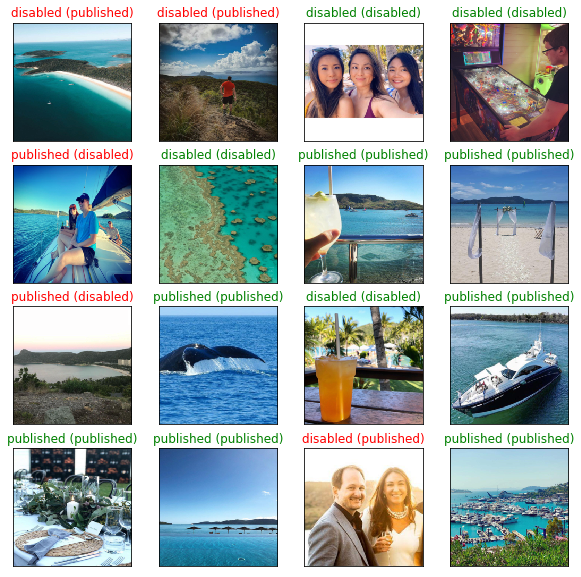

In [7]:
dataiter = iter(test_dataloader)

def visualise_predictions(dataiter, model, classes):
    images, labels = next(dataiter)
    
    if train_on_gpu:
        images = images.cuda()
        
    fig = plt.figure(figsize=(10, 10))
    num_samples = labels.size(0)
    cols = 4
    for i in range(num_samples):
        ax = fig.add_subplot(num_samples//4, cols, i+1, xticks=[], yticks=[])
        img = images[i]
    
        out = model(img.unsqueeze(0))
        _, pred = torch.max(out, 1)
        
        if train_on_gpu:
            pred = pred.cpu()
            img = inv_normalize(img)
            img = img.cpu()

        
        pred_class = classes[np.squeeze(pred.numpy())]
        true_class = classes[labels[i]]
     
        plt.imshow(np.transpose(img, (1,2,0)))
        color = 'green' if pred_class == true_class else 'red'
        ax.set_title("{} ({})".format(pred_class, true_class), color=color)
    
visualise_predictions(dataiter, best_model, classes)